In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import missingno as msno
%matplotlib inline

In [2]:
import plotly 

# Gathering

FAOSTAT provides free access to food and agriculture data for over 245 countries and territories and covers all FAO regional groupings from 1961 to the most recent year available.

http://www.fao.org/faostat/en/#home

For the purpose of this project, we will use the following data based on the last year available:

- Food Balance:
    - Vegetal products, Animal products.
    - Import, Export, Domestic Supply,...


- Annual population:
    - Total number of inhabitants 
    
    
N.B: The Chinese provinces need to be removed from the global selection.  
    
    
- ISO corresponding table:
    - https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes

In [188]:
# Load Data
veg = pd.read_csv(Path.cwd()/'veg.csv')
ani = pd.read_csv(Path.cwd()/'ani.csv')
pop = pd.read_csv(Path.cwd()/'pop.csv')

iso = pd.read_csv(Path.cwd()/'ISO'/'all'/'all.csv')

# Cleaning raw data

## Population dataset

In [4]:
pop.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,AF,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,36296.113,X,International reliable sources,NaN
1,OA,Annual population,AL,Albania,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,2884.169,X,International reliable sources,NaN
2,OA,Annual population,DZ,Algeria,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,41389.189,X,International reliable sources,NaN
3,OA,Annual population,AS,American Samoa,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,55.620,X,International reliable sources,NaN
4,OA,Annual population,AD,Andorra,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,77.001,X,International reliable sources,NaN


In [5]:
# Check the data quality (sources)
pop['Flag Description'].unique()

array(['International reliable sources',
       'Aggregate, may include official, semi-official, estimated or calculated data'],
      dtype=object)

In [6]:
# Which country got data of type: 'Aggregate, may include official, semi-official, estimated or calculated data' ?
pop[pop['Flag Description'] == 'Aggregate, may include official, semi-official, estimated or calculated data']

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
43,OA,Annual population,351,China,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,1452625.244,A,"Aggregate, may include official, semi-official...",NaN
145,OA,Annual population,AN,Netherlands Antilles (former),511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,275.186,A,"Aggregate, may include official, semi-official...",NaN


In [7]:
# Remove The Netherlands Antilles from the analysis
pop = pop[pop.Area != 'Netherlands Antilles (former)']

<div class= 'alert alert-block alert-info'>
The annual population of China is not considered as reliable as the others data. It is such an important country for the analysis that we decide to keep it anyway.
We also have a row for the Netherlands Antilles which have been dissolved on the 9th of September 2010 (https://en.wikipedia.org/wiki/Netherlands_Antilles#Dissolution). Considering the size of the country, we decide not to keep it for the rest of the analysis.
</div>

In [8]:
# Check the Unit
pop['Unit'].unique()

array(['1000 persons'], dtype=object)

In [9]:
# Change unit
pop['population'] = pop['Value']*1000

<div class= 'alert alert-block alert-info'>
Every country is expressed with the same unit. We decide to convert it into inhabitants to simplify further calculations.
</div>

In [10]:
# Selection of interest
pop = pop[['Area Code','Area','population']]
pop.head()

,Area Code,Area,population
0,AF,Afghanistan,36296113.0
1,AL,Albania,2884169.0
2,DZ,Algeria,41389189.0
3,AS,American Samoa,55620.0
4,AD,Andorra,77001.0


In [13]:
# Check Format
pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 232
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area Code   231 non-null    object 
 1   Area        232 non-null    object 
 2   population  232 non-null    float64
dtypes: float64(1), object(2)
memory usage: 7.2+ KB


In [14]:
# Check NaN
pop.isna().sum()

Area Code     1
Area          0
population    0
dtype: int64

In [15]:
# Check the row with NaN
pop[pop['Area Code'].isna() == True]

,Area Code,Area,population
141,NaN,Namibia,2402633.0


In [16]:
# Add missing code
pop['Area Code'] = np.where(pop['Area'] == 'Namibia','NA',pop['Area Code'])
pop[pop['Area Code'] == 'NA'] # Check results

,Area Code,Area,population
141,NA,Namibia,2402633.0


<div class= 'alert alert-block alert-info'> 

- The format of each variables is Ok.
- We fix the missing value.
    
Everything seems to be clear and clean on that dataset.
</div>

In [17]:
# Add info of regions and sub-regions for further analysis
pop = pd.merge(pop,iso[['alpha-2','region','sub-region']], left_on = 'Area Code', right_on='alpha-2', how='left')
pop.head()

,Area Code,Area,population,alpha-2,region,sub-region
0,AF,Afghanistan,36296113.0,AF,Asia,Southern Asia
1,AL,Albania,2884169.0,AL,Europe,Southern Europe
2,DZ,Algeria,41389189.0,DZ,Africa,Northern Africa
3,AS,American Samoa,55620.0,AS,Oceania,Polynesia
4,AD,Andorra,77001.0,AD,Europe,Southern Europe


In [18]:
# Check missing values again afetr merge
pop.isna().sum()

Area Code     0
Area          0
population    0
alpha-2       9
region        9
sub-region    9
dtype: int64

In [19]:
# Check the rows with NaN
pop[pop['region'].isna() == True]

,Area Code,Area,population,alpha-2,region,sub-region
25,278,"Bonaire, Sint Eustatius and Saba",2.540100e+04,NaN,NaN,NaN
41,259,Channel Islands,1.686650e+05,NaN,NaN,NaN
43,351,China,1.452625e+09,NaN,NaN,NaN
52,279,Curaçao,1.619970e+05,NaN,NaN,NaN
141,NA,Namibia,2.402633e+06,NaN,NaN,NaN
157,299,Palestine,4.747227e+06,NaN,NaN,NaN
173,282,Saint Barthélemy,9.784000e+03,NaN,NaN,NaN
179,281,Saint-Martin (French part),3.656000e+04,NaN,NaN,NaN
189,280,Sint Maarten (Dutch part),4.144400e+04,NaN,NaN,NaN


In [20]:
# Add missing code
pop['region'] = np.where(pop['Area'] == 'Namibia','Africa',pop['region'])
pop['sub-region'] = np.where(pop['Area'] == 'Namibia','Sub-Saharan Africa',pop['sub-region'])

pop['region'] = np.where(pop['Area'] == 'China','Asia',pop['region'])
pop['sub-region'] = np.where(pop['Area'] == 'China','South-eastern Asia',pop['sub-region'])

pop[(pop['Area Code'] == 'NA') | (pop['Area Code'] == '351') ] # Check results

,Area Code,Area,population,alpha-2,region,sub-region
43,351,China,1.452625e+09,NaN,Asia,South-eastern Asia
141,NA,Namibia,2.402633e+06,NaN,Africa,Sub-Saharan Africa


<div class= 'alert alert-block alert-info'> 

The missing values concern mostly territories attached to another country like the Netherlands (Bonaire, Sint Eustatius and Saba, Curaçao,Sint Maarten), 
UK (Channel Islands and France (Saint Barthélemy,Saint-Martin). We decide to drop these territories from the analysis.
    
For China and Namibia, we decide to complete the missing values manually.
</div>

In [21]:
# Create processed dataframe
pop.drop(['alpha-2','Area Code'],axis=1,inplace=True)
pop.dropna(inplace=True)

,Area,population,region,sub-region
0,Afghanistan,36296113.0,Asia,Southern Asia
1,Albania,2884169.0,Europe,Southern Europe
2,Algeria,41389189.0,Africa,Northern Africa
3,American Samoa,55620.0,Oceania,Polynesia
4,Andorra,77001.0,Europe,Southern Europe


## Food dataset

In [22]:
# Creation of dataset Food

    # Add variable origin
ani["origin"] = "animal"
veg["origin"] = "vegetal"

    # Merge 2 datasets
food = ani.append(veg)
food.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,origin
0,FBS,New Food Balances,2,Afghanistan,5511,Production,2731,Bovine Meat,2017,2017,1000 tonnes,94.0,S,Standardized data,animal
1,FBS,New Food Balances,2,Afghanistan,5611,Import Quantity,2731,Bovine Meat,2017,2017,1000 tonnes,6.0,S,Standardized data,animal
2,FBS,New Food Balances,2,Afghanistan,5072,Stock Variation,2731,Bovine Meat,2017,2017,1000 tonnes,-0.0,S,Standardized data,animal
3,FBS,New Food Balances,2,Afghanistan,5301,Domestic supply quantity,2731,Bovine Meat,2017,2017,1000 tonnes,100.0,S,Standardized data,animal
4,FBS,New Food Balances,2,Afghanistan,5123,Losses,2731,Bovine Meat,2017,2017,1000 tonnes,5.0,S,Standardized data,animal


In [23]:
# Check data quality (sources reliability)
food['Flag Description'].unique()

array(['Standardized data', 'Calculated data',
       'Aggregate, may include official, semi-official, estimated or calculated data'],
      dtype=object)

In [24]:
# Which country does not have Standardized or Calculated data?
food[food['Flag Description'] == 'Aggregate, may include official, semi-official, estimated or calculated data']['Area'].unique()

array(['China'], dtype=object)

<div class= 'alert alert-block alert-info'> Same comment than before, even if the chinese data are not as reliable than the others, we keep them for the analysis.
   In addition, we can notice that we have 3 types of data: Calculated, Standardized and aggregate. That information is important if we find some discrepancies.
</div>

In [25]:
# Check units
food.groupby(['Element']).Unit.unique()

Element
Domestic supply quantity                      [1000 tonnes]
Export Quantity                               [1000 tonnes]
Fat supply quantity (g/capita/day)           [g/capita/day]
Feed                                          [1000 tonnes]
Food                                          [1000 tonnes]
Food supply (kcal/capita/day)             [kcal/capita/day]
Food supply quantity (kg/capita/yr)                    [kg]
Import Quantity                               [1000 tonnes]
Losses                                        [1000 tonnes]
Other uses (non-food)                         [1000 tonnes]
Processing                                    [1000 tonnes]
Production                                    [1000 tonnes]
Protein supply quantity (g/capita/day)       [g/capita/day]
Residuals                                     [1000 tonnes]
Seed                                          [1000 tonnes]
Stock Variation                               [1000 tonnes]
Tourist consumption             

<div class='alert alert-block alert-warning'>
Food supply is not expressed in the right units: supposed to be kg/capita/yr but it's in kg. Let's fix this. </div>

In [26]:
# Selection of interest
df = food[['Area','Element','Item','Value','Unit','origin']]

In [27]:
# Add info from population
df = pd.merge(df,pop, on='Area',how='inner')
df.head()

,Area,Element,Item,Value,Unit,origin,population,region,sub-region
0,Afghanistan,Production,Bovine Meat,94.0,1000 tonnes,animal,36296113.0,Asia,Southern Asia
1,Afghanistan,Import Quantity,Bovine Meat,6.0,1000 tonnes,animal,36296113.0,Asia,Southern Asia
2,Afghanistan,Stock Variation,Bovine Meat,-0.0,1000 tonnes,animal,36296113.0,Asia,Southern Asia
3,Afghanistan,Domestic supply quantity,Bovine Meat,100.0,1000 tonnes,animal,36296113.0,Asia,Southern Asia
4,Afghanistan,Losses,Bovine Meat,5.0,1000 tonnes,animal,36296113.0,Asia,Southern Asia


In [28]:
# Create new column with correct value for Food supply quantity 
df['val'] = np.where((df.Element == 'Food supply quantity (kg/capita/yr)'),df.Value/df.population,df.Value) # replace the value
df['Unit'] = np.where((df.Element == 'Food supply quantity (kg/capita/yr)'),'kg/capita/yr',df.Unit) # replace the unit
df.drop(['Value'],axis=1,inplace=True)

In [146]:
# Drop column Unit
df.drop(['Unit'],axis=1,inplace=True)

# Structuring 

In [148]:
# Let's pivot the table now to make it more readable for the analysis

fdp = df.pivot_table(

    index=["region","sub-region","Area","Item",'origin','population'],

    columns = ["Element"], values=["val"], aggfunc=sum)

fdp.head()

val  \
Element                                                                   Domestic supply quantity   
region sub-region      Area    Item                    origin  population                            
Africa Northern Africa Algeria Alcohol, Non-Food       vegetal 41389189.0                      1.0   
                               Apples and products     vegetal 41389189.0                    495.0   
                               Aquatic Animals, Others animal  41389189.0                      0.0   
                               Aquatic Plants          animal  41389189.0                      0.0   
                               Bananas                 vegetal 41389189.0                     96.0   

                                                                                           \
Element                                                                   Export Quantity   
region sub-region      Area    Item                    origin  population                   
Africa Northern Africa Algeria Alcohol, Non-Food       vegetal 41389189.0             NaN   
                               Apples and products     vegetal 41389189.0             0.0   
                               Aquatic Animals, Others animal  41389189.0             NaN   
                               Aquatic Plants          animal  41389189.0             0.0   
                               Bananas                 vegetal 41389189.0             NaN   

                                                                                                              \
Element                                                                   Fat supply quantity (g/capita/day)   
region sub-region      Area    Item                    origin  population                                      
Africa Northern Africa Algeria Alcohol, Non-Food       vegetal 41389189.0                                NaN   
                               Apples and products     vegetal 41389189.0                               0.09   
                               Aquatic Animals, Others animal  41389189.0                               0.00   
                               Aquatic Plants          animal  41389189.0                               0.00   
                               Bananas                 vegetal 41389189.0                               0.01   

                                                                                \
Element                                                                   Feed   
region sub-region      Area    Item                    origin  population        
Africa Northern Africa Algeria Alcohol, Non-Food       vegetal 41389189.0  NaN   
                               Apples and products     vegetal 41389189.0  NaN   
                               Aquatic Animals, Others animal  41389189.0  NaN   
                               Aquatic Plants          animal  41389189.0  NaN   
                               Bananas                 vegetal 41389189.0  NaN   

                                                                                  \
Element                                                                     Food   
region sub-region      Area    Item                    origin  population          
Africa Northern Africa Algeria Alcohol, Non-Food       vegetal 41389189.0    NaN   
                               Apples and products     vegetal 41389189.0  470.0   
                               Aquatic Animals, Others animal  41389189.0    0.0   
                               Aquatic Plants          animal  41389189.0    0.0   
                               Bananas                 vegetal 41389189.0   86.0   

                                                                                                         \
Element                                                                   Food supply (kcal/capita/day)   
region sub-region      Area    Item                    origin  population                   

In [149]:
# Flatten the dataframe
fdp = fdp.xs('val', axis=1, drop_level=True)

## Données bilan alimentaire + sous-nutrition

### Nettoyage et Formatage du dataset

In [90]:
# Jointure des tables bilan alimentaire et population en sous nutrition

data = pd.merge(data, sousnut, on = ["country_code",'country','year'], how = 'inner')

data.head()

,country_code,country,year,origin,item_code,item,Domestic supply,Export,Fat supply (g/capita/day),Animal Food,...,Ratio Proteines/poids (% prot),Ressource VG,Ressource VG (kcal),Ressource VG (g prot),is_cereal,Ressources perdues (kcal),Animal Food (en kcal),Domestic supply (en kcal),Domestic supply (en kg de prot),pop sous nut
0,1,Armenia,2012,animal,2731,Bovine Meat,58000.0,0.0,8.22,0.0,...,14.228352,57000.0,1.125535e+11,8.110161e+09,False,0.0,0.0,1.145281e+11,8.252444e+06,100000.0
1,1,Armenia,2012,animal,2732,Mutton & Goat Meat,9000.0,0.0,1.79,0.0,...,12.389062,9000.0,2.208993e+10,1.115016e+09,False,0.0,0.0,2.208993e+10,1.115016e+06,100000.0
2,1,Armenia,2012,animal,2733,Pigmeat,28000.0,0.0,5.87,0.0,...,8.882724,27000.0,6.626980e+10,2.398335e+09,False,0.0,0.0,6.872423e+10,2.487163e+06,100000.0
3,1,Armenia,2012,animal,2734,Poultry Meat,41000.0,0.0,2.93,0.0,...,12.084040,41000.0,4.943937e+10,4.954456e+09,False,0.0,0.0,4.943937e+10,4.954456e+06,100000.0
4,1,Armenia,2012,animal,2735,Meat Other,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.000000e+00,0.000000e+00,False,0.0,0.0,0.000000e+00,0.000000e+00,100000.0


In [91]:
# Nettoyage des donnees

data = data.replace([np.nan, np.inf, -np.inf],0)

# Cleaning processed data

## Missing Values

In [150]:
# Check %NaN by Variables
fdp.isna().sum()/fdp.shape[0]

Element
Domestic supply quantity                  0.009007
Export Quantity                           0.246797
Fat supply quantity (g/capita/day)        0.096029
Feed                                      0.738298
Food                                      0.096917
Food supply (kcal/capita/day)             0.098313
Food supply quantity (kg/capita/yr)       0.089306
Import Quantity                           0.049600
Losses                                    0.636369
Other uses (non-food)                     0.670874
Processing                                0.778764
Production                                0.355448
Protein supply quantity (g/capita/day)    0.096347
Residuals                                 0.216986
Seed                                      0.866992
Stock Variation                           0.296017
Tourist consumption                       0.656539
dtype: float64

<AxesSubplot:xlabel='Element'>

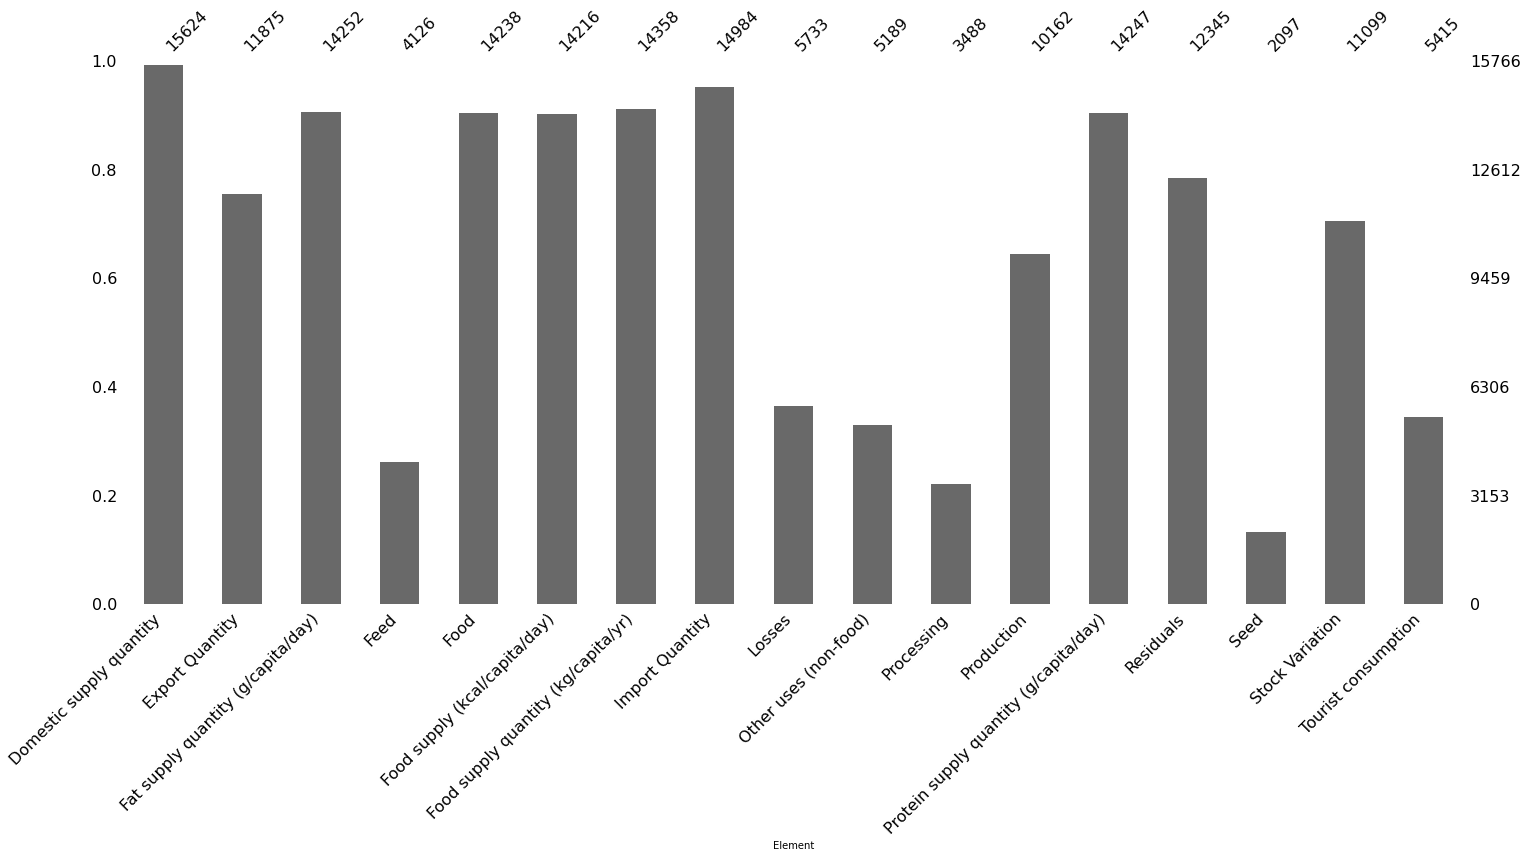

In [151]:
# Visualise NaN
msno.bar(fdp)

In [152]:
# Remove the columns with more than 60% of NaN values
fdp2 = fdp.loc[:, fdp.isna().sum()/fdp.shape[0]<0.6]
fdp2.isna().sum()/fdp2.shape[0]

Element
Domestic supply quantity                  0.009007
Export Quantity                           0.246797
Fat supply quantity (g/capita/day)        0.096029
Food                                      0.096917
Food supply (kcal/capita/day)             0.098313
Food supply quantity (kg/capita/yr)       0.089306
Import Quantity                           0.049600
Production                                0.355448
Protein supply quantity (g/capita/day)    0.096347
Residuals                                 0.216986
Stock Variation                           0.296017
dtype: float64

<div class='alert alert-block alert-info'> The columns Export, Production, Residuals and Stock Variation have about 22 to 35% of missing values. We keep them for now, but we have 
to be cautious during the interpretation phasis if we used them.
</div>

<AxesSubplot:xlabel='Element', ylabel='Element'>

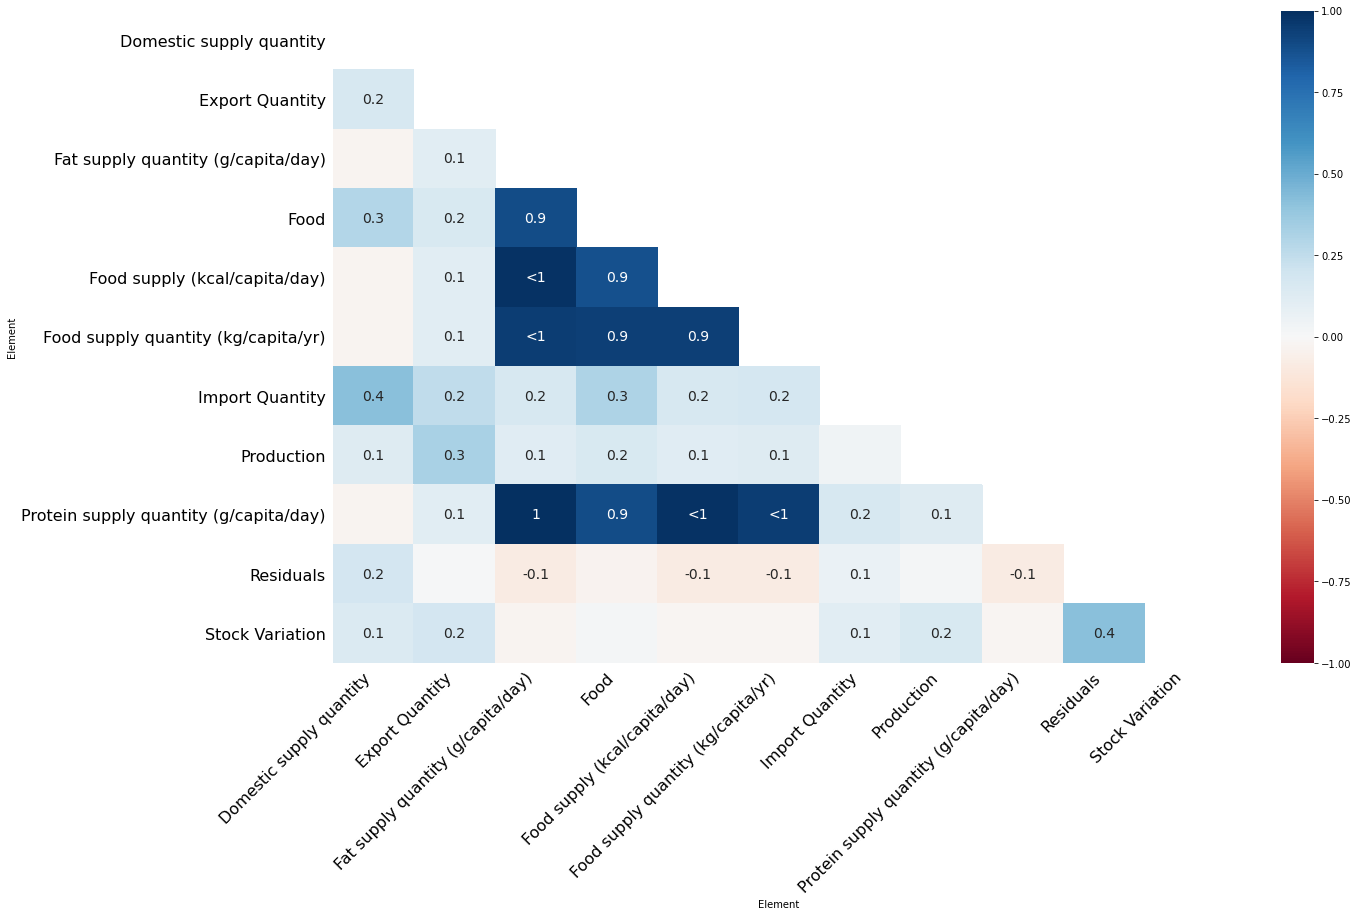

In [153]:
# What to do with the NaN left?
msno.heatmap(fdp2)

In [154]:
fdp2[fdp2['Protein supply quantity (g/capita/day)'].isna() == True].describe()

Element,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Production,Protein supply quantity (g/capita/day),Residuals,Stock Variation
count,1517.000000,915.000000,7.0,143.000000,1.0,1.240000e+02,1274.000000,700.000000,0.0,1347.000000,1118.000000
mean,798.862887,45.707104,0.0,0.139860,0.0,1.074069e-11,26.334380,1754.967143,NaN,-4.985895,7.432916
std,9234.188037,378.448615,0.0,0.667151,NaN,1.196033e-10,123.992415,14133.637387,NaN,101.594578,835.085304
min,-663.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,NaN,-2912.000000,-10388.000000
25%,0.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,6.000000,NaN,0.000000,0.000000
75%,14.000000,2.000000,0.0,0.000000,0.0,0.000000e+00,3.000000,85.250000,NaN,0.000000,0.000000
max,280979.000000,9729.000000,0.0,6.000000,0.0,1.331846e-09,1903.000000,306069.000000,NaN,1237.000000,25089.000000


<div class='alert alert-block alert-info'> We can see that when protein supply is missing the other calculated fields mostly populated with null values or very low values. We decide to drop the rows with null values when protein supply is missing and investigate on the others left. </div>

In [155]:
# Selecting the rows with zero values
df2 = fdp2[fdp2.select_dtypes('number').values == 0]

In [156]:
# Removing the rows when protein supply is missing
df2 = df2[(df2['Protein supply quantity (g/capita/day)'].isna() != True)]

<AxesSubplot:xlabel='Element', ylabel='Element'>

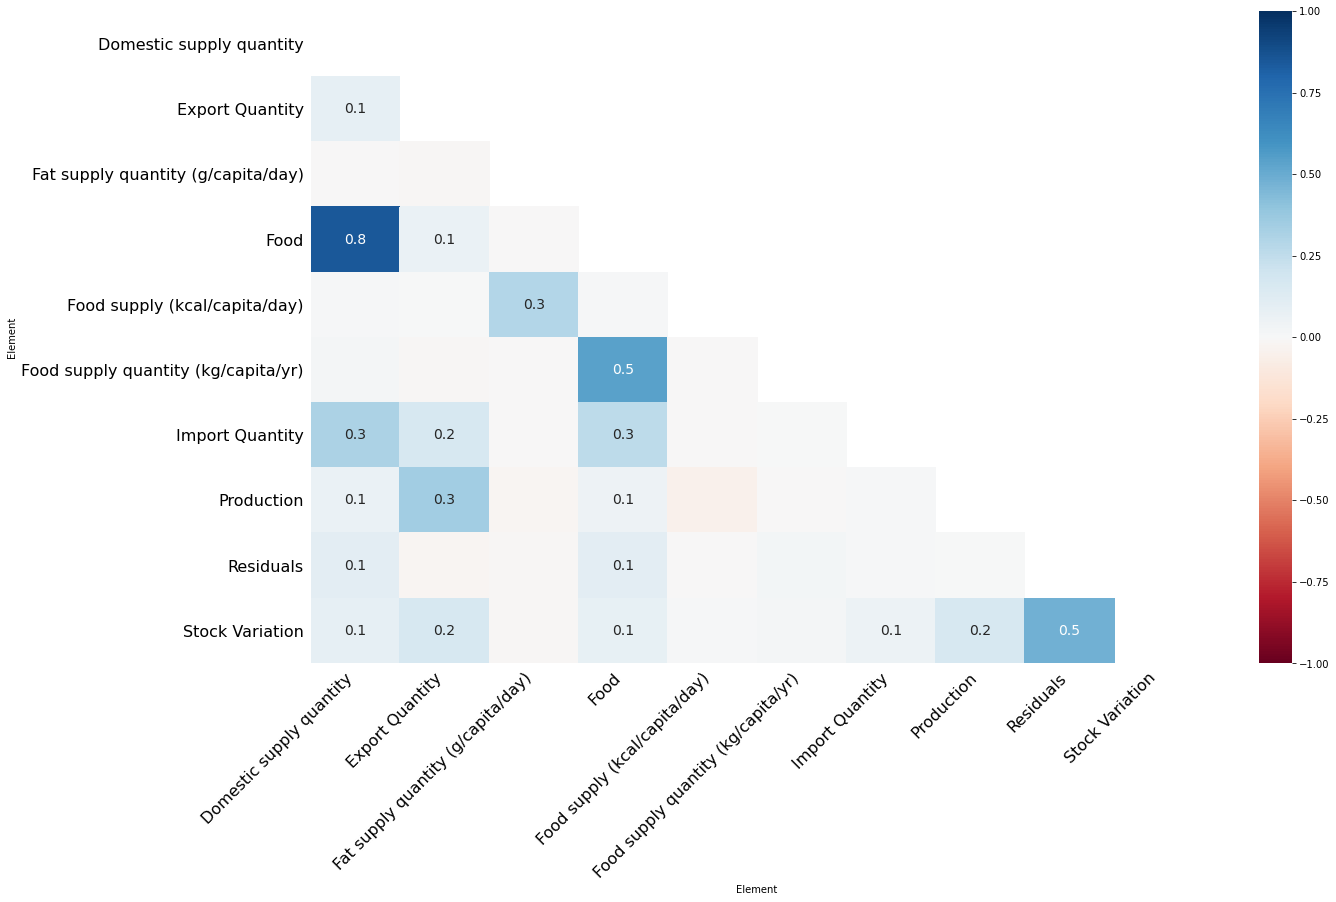

In [157]:
# Checking the effect
msno.heatmap(df2)

<div class='alert alert-block alert-info'> Now we can see that except for food and Domestic supply, the missing values are not really correlated to each others. Let's handle the last case: when Domestic supply data are missing.
</div>

In [158]:
df2[df2['Domestic supply quantity'].isna() == True].describe()

Element,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Production,Protein supply quantity (g/capita/day),Residuals,Stock Variation
count,0.0,0.0,195.000000,0.0,192.000000,1.920000e+02,0.0,0.0,195.000000,0.0,0.0
mean,NaN,NaN,0.195436,NaN,4.994792,7.208716e-08,NaN,NaN,0.020103,NaN,NaN
std,NaN,NaN,1.511316,NaN,19.561019,2.957323e-07,NaN,NaN,0.217362,NaN,NaN
min,NaN,NaN,0.000000,NaN,0.000000,0.000000e+00,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,0.000000,0.000000e+00,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,0.000000,0.000000e+00,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,0.000000,4.314663e-09,NaN,NaN,0.000000,NaN,NaN
max,NaN,NaN,19.720000,NaN,174.000000,2.417649e-06,NaN,NaN,3.020000,NaN,NaN


In [159]:
len(df2[df2['Domestic supply quantity'].isna() == True])/len(df2)

0.00350372832629593

In [160]:
df2 = df2[df2['Domestic supply quantity'].isna() != True]

<div class='alert alert-block alert-info'> There are a few amount of rows with Domestic Supply with missing data and for the ones concerned, all the others fields related to the Quantity are also missing.
How can we rely on these data when Quantity is null but the ratios are not null?
We decide to drop these rows.
</div>

In [161]:
df2.isna().sum()

Element
Domestic supply quantity                      0
Export Quantity                           16264
Fat supply quantity (g/capita/day)           18
Food                                         77
Food supply (kcal/capita/day)               206
Food supply quantity (kg/capita/yr)          77
Import Quantity                            1708
Production                                26028
Protein supply quantity (g/capita/day)        0
Residuals                                 12511
Stock Variation                           17256
dtype: int64

In [162]:
# Case 1 - Production is NaN
df2[df2['Production'].isna()==True].describe()

Element,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Production,Protein supply quantity (g/capita/day),Residuals,Stock Variation
count,26028.000000,14046.00000,26028.000000,25997.000000,26016.000000,2.599700e+04,25286.000000,0.0,26028.000000,20226.000000,15883.000000
mean,4.268826,3.29261,0.144693,2.757241,2.755919,1.397315e-06,6.458000,NaN,0.045122,-0.571146,0.333879
std,46.399461,41.40722,1.103357,24.495556,19.398883,1.504005e-05,54.263008,NaN,0.403594,15.079901,6.590169
min,-719.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,NaN,0.000000,-719.000000,-52.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,NaN,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,NaN,0.000000,0.000000,0.000000
75%,0.000000,0.00000,0.010000,0.000000,1.000000,2.662919e-08,1.000000,NaN,0.000000,0.000000,0.000000
max,1484.000000,1284.00000,41.810000,1484.000000,697.000000,7.766356e-04,1544.000000,NaN,19.310000,306.000000,342.000000


In [163]:
len(df2[(df2['Production'].isna()==True) & (df2['Domestic supply quantity'] == 0) & (df2['Export Quantity'] == 0) & (df2['Import Quantity'] == 0)])

8325

<div class='alert alert-block alert-info'> Same logic than before, we drop these rows as we can't really rely on the ratios when all the rest is null.
</div>

In [164]:
df2 = df2[(df2['Production'].isna()!=True) & (df2['Domestic supply quantity'] != 0) & (df2['Export Quantity'] != 0) & (df2['Import Quantity'] != 0)]

In [165]:
df2.isna().sum()

Element
Domestic supply quantity                     0
Export Quantity                           1066
Fat supply quantity (g/capita/day)           0
Food                                         0
Food supply (kcal/capita/day)                0
Food supply quantity (kg/capita/yr)          0
Import Quantity                            311
Production                                   0
Protein supply quantity (g/capita/day)       0
Residuals                                  901
Stock Variation                            927
dtype: int64

In [166]:
# Fill NaN values with zeros for the rest
df2.fillna(0, inplace=True)
df2.head()

Element                                                                 Domestic supply quantity  \
region sub-region      Area    Item                 origin  population                             
Africa Northern Africa Algeria Bananas              vegetal 41389189.0                      96.0   
                                                            41389189.0                      96.0   
                               Barley and products  vegetal 41389189.0                    1536.0   
                                                            41389189.0                    1536.0   
                               Beverages, Alcoholic vegetal 41389189.0                       6.0   

Element                                                                 Export Quantity  \
region sub-region      Area    Item                 origin  population                    
Africa Northern Africa Algeria Bananas              vegetal 41389189.0              0.0   
                                                            41389189.0              0.0   
                               Barley and products  vegetal 41389189.0              0.0   
                                                            41389189.0              0.0   
                               Beverages, Alcoholic vegetal 41389189.0              0.0   

Element                                                                 Fat supply quantity (g/capita/day)  \
region sub-region      Area    Item                 origin  population                                       
Africa Northern Africa Algeria Bananas              vegetal 41389189.0                                0.01   
                                                            41389189.0                                0.01   
                               Barley and products  vegetal 41389189.0                                0.28   
                                                            41389189.0                                0.28   
                               Beverages, Alcoholic vegetal 41389189.0                                0.00   

Element                                                                  Food  \
region sub-region      Area    Item                 origin  population          
Africa Northern Africa Algeria Bananas              vegetal 41389189.0   86.0   
                                                            41389189.0   86.0   
                               Barley and products  vegetal 41389189.0  520.0   
                                                            41389189.0  520.0   
                               Beverages, Alcoholic vegetal 41389189.0    6.0   

Element                                                                 Food supply (kcal/capita/day)  \
region sub-region      Area    Item                 origin  population                                  
Africa Northern Africa Algeria Bananas              vegetal 41389189.0                            3.0   
                                                            41389189.0                            3.0   
                               Barley and products  vegetal 41389189.0                           90.0   
                                                            41389189.0                           90.0   
                               Beverages, Alcoholic vegetal 41389189.0                            1.0   

Element                                                                 Food supply quantity (kg/capita/yr)  \
region sub-region      Area    Item                 origin  population                                        
Africa Northern Africa Algeria Bananas              vegetal 41389189.0                         5.049628e-08   
                                                            41389189.0                         5.049628e-08   
                               Barley and products  vegetal 41389189.0                         3.037025e-07   
                               

<div class='alert alert-block alert-info'> We decide to fill the rest of NaN with zeros. There are a few amount of missing values for the ratios columns. For the others columns
</div>

## Errors values

In [167]:
df2.describe()

Element,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Production,Protein supply quantity (g/capita/day),Residuals,Stock Variation
count,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8.152000e+03,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000
mean,934.547596,238.023553,1.443459,410.183759,50.144872,6.018862e-06,187.173086,998.689401,1.015336,-3.170388,13.326914
std,7220.283282,2423.439062,4.254556,2954.172521,115.939170,3.897828e-05,1257.538081,8204.664074,3.292374,46.046219,327.496179
min,-204.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-1217.000000,-9389.000000
25%,10.000000,1.000000,0.000000,2.000000,1.000000,3.352972e-09,4.000000,1.000000,0.000000,0.000000,0.000000
50%,54.000000,7.000000,0.020000,21.000000,9.000000,1.009518e-07,18.000000,25.000000,0.030000,0.000000,0.000000
75%,273.000000,53.000000,0.500000,136.000000,41.000000,1.054022e-06,91.000000,208.000000,0.470000,0.000000,1.000000
max,345852.000000,68156.000000,60.100000,176896.000000,1785.000000,1.084812e-03,98119.000000,397603.000000,48.680000,1870.000000,6143.000000


<div class='alert alert-block alert-info'> Negative value in the column Domestic supply quantity is not normal </div>

In [168]:
# Is the value domestic supply reliable? Let's recalculate it.
list_sum1 = ('Production','Import Quantity','Stock Variation')

df2['Domestic_supply_calc1'] = (df2.loc[:,list_sum1].sum(axis=1)-df2['Export Quantity'])

# Calculate the %variation btw the original column and the new one
df2['var'] = abs(df2['Domestic_supply_calc1'] - df2['Domestic supply quantity'])*100/df2['Domestic supply quantity']

In [169]:
# Do we find the same negative values?
tmp = df2[(df2['Domestic supply quantity'].values < 0)]
tmp2 = tmp[(tmp['var'] !=0)& (tmp['Domestic_supply_calc1']<0)]
print(1-(len(tmp2)/len(tmp)))

0.7840909090909091


In [170]:
len(tmp)

176

In [171]:
len(tmp)/len(df2)*100

2.1589793915603535

In [172]:
df3 = df2[(df2['Domestic supply quantity'].values > 0)]
df3.describe()

Element,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Production,Protein supply quantity (g/capita/day),Residuals,Stock Variation,Domestic_supply_calc1,var
count,7976.000000,7976.000000,7976.000000,7976.000000,7976.000000,7.976000e+03,7976.000000,7976.000000,7976.000000,7976.000000,7976.000000,7976.000000,7976.000000
mean,955.626630,241.574223,1.473845,419.176279,51.227558,6.150813e-06,190.873872,1019.912362,1.037229,-2.608826,13.622743,982.834754,28.749705
std,7298.108597,2449.817452,4.295755,2985.964827,116.977803,3.939580e-05,1271.077152,8293.434164,3.325125,45.841216,331.083873,7260.460933,147.810448
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-1217.000000,-9389.000000,-782.000000,0.000000
25%,12.000000,1.000000,0.000000,2.000000,1.000000,4.214491e-09,4.000000,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000
50%,57.000000,7.000000,0.020000,23.000000,10.000000,1.083439e-07,18.000000,27.000000,0.030000,0.000000,0.000000,60.000000,0.990099
75%,285.000000,52.000000,0.530000,141.000000,43.000000,1.120746e-06,94.000000,222.250000,0.490000,0.000000,1.000000,305.000000,15.853659
max,345852.000000,68156.000000,60.100000,176896.000000,1785.000000,1.084812e-03,98119.000000,397603.000000,48.680000,1870.000000,6143.000000,345852.000000,4600.000000


<div class='alert alert-block alert-info'> 78% of the rows with negatives values are indeed negatives based on the calculations. 
So 22% of rows with negatives values, shouldn't be negative based on our calculations. We could choose to keep the rows when the sign of the two columns are similar (both are negatives and both are positive) and drop the ones when we calculate a positive values and we got a negative value in the dataset. Or, as the negatives values represent only 2% of the dataset we could decide to drop all rows with negative values in the column Domestic Supply quantity. We choose this option to simplify the analysis.
</div>

# Enriching

## Food supply (kcal) & (kg)

In [173]:
data = df3.reset_index()
data.columns

Index(['region', 'sub-region', 'Area', 'Item', 'origin', 'population',
       'Domestic supply quantity', 'Export Quantity',
       'Fat supply quantity (g/capita/day)', 'Food',
       'Food supply (kcal/capita/day)', 'Food supply quantity (kg/capita/yr)',
       'Import Quantity', 'Production',
       'Protein supply quantity (g/capita/day)', 'Residuals',
       'Stock Variation', 'Domestic_supply_calc1', 'var'],
      dtype='object', name='Element')

In [197]:
# Creation of columns
data['Food supply (kcal)'] = data['Food supply (kcal/capita/day)'] * data['population']*365
data['Food supply (kg prot)'] = data['Protein supply quantity (g/capita/day)'] * data['population']* 365 / 1000

## Ratios

In [198]:
# Creation column Energy/Weight
data['Ratio E/W (kcal / 100 g)'] = data['Food supply (kcal)'] / (data['Food']*10**4)

In [199]:
# Creation column Proteines/poids
data['Ratio Prot/W (% prot)']= (data['Food supply (kg prot)'] / (data['Food']*10))

## Domestic Supply (kcal/cap/day)

In [201]:
# Creation column based on original column
data['Domestic supply (kcal/cap/d)'] = data['Domestic supply quantity']*10**4*data['Ratio E/W (kcal / 100 g)']/ data['population']/365

In [204]:
# Creation column based on the calculated column
data['Domestic supply2 (kcal/cap/d)'] = data['Domestic_supply_calc1']*10**4*data['Ratio E/W (kcal / 100 g)']/ data['population']/365

## Under Nutrition

According to the FAO, the daily energy intake goes from 1550 to 4500 kcal/pers/day dependaing on the weight, age, gender and activity.

http://www.fao.org/3/y5686e/y5686e08.htm

In [205]:
# Let's use the minimum value as a threshold to assess which country and so the number of people under nourished
tmp = data.groupby(['Area']).sum()
tmp.head()

Element,population,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Production,Protein supply quantity (g/capita/day),...,var,Food supply (kcal),Food supply (kg de prot),Ratio Energie/poids (kcal / 100 g),Ratio Proteines/poids (% prot),Food supply (kg prot),Ratio E/W (kcal / 100 g),Ratio Prot/W (% prot),Domestic supply (kcal/cap/d),Domestic supply2 (kcal/cap/d)
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,3.266650e+08,820.0,51.0,4.45,692.0,90.0,5.262271e-07,360.0,912.0,5.81,...,302.590458,1.192327e+12,7.697135e+07,2.197466e+06,125722.221937,7.697135e+07,2.197466e+06,125722.221937,103.033151,143.104251
Albania,6.922006e+07,1999.0,167.0,19.46,1649.0,1536.0,1.984072e-04,678.0,1539.0,44.79,...,666.805781,1.616981e+12,4.715140e+07,2.658726e+06,137330.274304,4.715140e+07,2.658726e+06,137330.274304,2182.472806,2215.307781
Algeria,1.738346e+09,45371.0,2327.0,42.88,33138.0,3539.0,1.934539e-05,19785.0,28334.0,72.62,...,127.110202,5.346386e+13,1.097074e+09,9.315521e+06,185105.100511,1.097074e+09,9.315521e+06,185105.100511,5137.699336,5340.789192
Angola,2.683509e+08,3330.0,59.0,15.69,2927.0,253.0,3.291772e-06,571.0,2760.0,6.32,...,29.068610,2.753429e+12,6.878132e+07,2.774378e+06,107690.481917,6.878132e+07,2.774378e+06,107690.481917,519.514607,471.604927
Antigua and Barbuda,4.771300e+05,7.0,0.0,7.49,7.0,181.0,6.439545e-04,7.0,0.0,13.31,...,0.000000,6.304319e+09,4.635938e+05,5.189743e+05,45070.654060,4.635938e+05,5.189743e+05,45070.654060,181.000000,181.000000


In [206]:
tmp = tmp[tmp['Domestic supply (kcal/cap/d)'] <= 1550]
len(tmp)

36

In [209]:
tmp.reset_index().Area.unique()

array(['Afghanistan', 'Angola', 'Antigua and Barbuda', 'Benin',
       'Burkina Faso', 'Cambodia', 'Congo', "Côte d'Ivoire",
       "Democratic People's Republic of Korea", 'Ecuador', 'Guinea',
       'Haiti', 'India', 'Iraq', 'Liberia', 'Madagascar', 'Mali',
       'Mongolia', 'Nepal', 'New Caledonia', 'Niger', 'Nigeria',
       'Pakistan', 'Rwanda', 'Saint Lucia', 'Samoa',
       'Sao Tome and Principe', 'Senegal', 'Sri Lanka', 'Tajikistan',
       'Timor-Leste', 'Turkmenistan', 'Vanuatu',
       'Venezuela (Bolivarian Republic of)', 'Yemen', 'Zambia'],
      dtype=object)

<div class='alert alert-block alert-info'> 36 countries are supposed to be under nourished with these threshold. Looking at the list, the output seems to be quite accurate. We can find most of them in a published article here: https://en.wikipedia.org/wiki/Epidemiology_of_malnutrition</div>

# Validating

In [11]:
# Check basics statistics info
pop.describe()

,population
count,2.320000e+02
mean,3.253387e+07
std,1.344249e+08
min,7.930000e+02
25%,3.803032e+05
50%,5.203510e+06
75%,1.930842e+07
max,1.452625e+09


In [178]:
# Check validity World population
pop17 = pop['population'].sum()
print("The World population in 2017 was :","%e"%pop17, "of human beings")

The World population in 2017 was : 7.542668e+09 of human beings


<div class= 'alert alert-block alert-info'> 

- We don't have extremes or weird values in the Statistics summary. The World population number is corroborated on the UN website: the world population in 2017 was about 7.6 billions of human beings. 
- The format of each variables is Ok.
- We fix the missing value.
    
Everything seems to be clear and clean on that dataset.
</div>

In [138]:
# Focus of Country with discrepancies > 5% for the column Domestic supply
tmp = df2[df2['var'] > 5][['Domestic supply quantity','Domestic_supply_calc1','var']]
len(tmp)/len(df2)

0.37475466143277725

In [141]:
# What types of data is predominant?
tmp = pd.merge(tmp, food[['Area','Item','Flag Description']], on = ['Area','Item'], how='inner')
tmp.groupby('Flag Description').count()

,Area,Item,Domestic supply quantity,Domestic_supply_calc1,var
Flag Description,,,,,
"Aggregate, may include official, semi-official, estimated or calculated data",374,374,374,374,374
Calculated data,12220,12220,12220,12220,12220
Standardized data,26798,26798,26798,26798,26798


<div class='alert alert-block alert-info'> 37% of the rows have a discrepancy between the calculated Domestic Supply and the original column.
The original column is composed for about 70% of Standardized data and about 30% of Calculated data. We don't have enough information about their method of calculation or standardization. Perhaps something is missing in our calculations.
We decide to stick on the data in the original values for now, as there is still 70% of reliable data (standaradized).
</div>
